In [1]:
from zipfile import ZipFile
with ZipFile('/content/titanic.zip','r') as zipObj:
  zipObj.extractall('/content/titanic')

In [2]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Create Validation Set
df_valid = pd.read_csv('/content/test.csv')
df_gender = pd.read_csv('/content/gender_submission.csv')

df_valid = pd.merge(df_valid, df_gender, on='PassengerId')
df_valid.dropna(subset=['Survived'], inplace=True)
df_valid.dropna(subset=['Fare'], inplace=True)

df_valid.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [6]:
def manual_preprocess_df(df):
    df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1)
    df['Embarked'] = df['Embarked'].map({
        'C' : 0,
        'Q' : 1,
        'S' : 2
    })
    df['Sex'] = df['Sex'].map({
        'male' : 0,
        'female' : 1
    })
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df.dropna(subset=['Embarked'], inplace=True)
    return df

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df_train = manual_preprocess_df(df_train)
df_valid = manual_preprocess_df(df_valid)

df_train.head()

In [9]:
#Label - Data Splits
def label_data_split(df):
    y = df['Survived']
    x = df.loc[:, df.columns != 'Survived']
    return (x,y)

In [10]:
#Train - Test Split & Shuffling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df_train = shuffle(df_train)

(labels, targets) = label_data_split(df_train)

x_train, x_test, y_train, y_test = train_test_split(labels, targets, test_size=0.33)

In [11]:
#Scaler
from sklearn.preprocessing import StandardScaler

D = 7

dataScaler = StandardScaler()

x_train = dataScaler.fit_transform(x_train)
x_test = dataScaler.transform(x_test)

In [12]:
#Build Model With TF Keras Functional API
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.models import Model

i = Input(shape=(D,1))
x = LSTM(32, return_sequences=True, activation=LeakyReLU(alpha=0.2))(i)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = LSTM(128, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [34]:
# prompt: show the lstm model

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 7, 32)             4352      
                                                                 
 dropout (Dropout)           (None, 7, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 64)             24832     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [13]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(
        learning_rate=0.01
    ),
    metrics = ['accuracy']
)

In [14]:
#Early Stop For Val_Accuracy
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=25)


In [15]:
r = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs = 150,
    callbacks=[early_stop]
)

Epoch 1/150
19/19 [==============================] - 7s 54ms/step - loss: 0.6790 - accuracy: 0.5950 - val_loss: 0.6666 - val_accuracy: 0.6463
Epoch 2/150
19/19 [==============================] - 1s 28ms/step - loss: 0.6447 - accuracy: 0.5916 - val_loss: 0.6191 - val_accuracy: 0.7109
Epoch 3/150
19/19 [==============================] - 1s 29ms/step - loss: 0.6021 - accuracy: 0.6756 - val_loss: 0.5915 - val_accuracy: 0.6871
Epoch 4/150
19/19 [==============================] - 1s 28ms/step - loss: 0.6071 - accuracy: 0.6891 - val_loss: 0.5704 - val_accuracy: 0.6803
Epoch 5/150
19/19 [==============================] - 1s 28ms/step - loss: 0.5929 - accuracy: 0.6773 - val_loss: 0.5965 - val_accuracy: 0.6769
Epoch 6/150
19/19 [==============================] - 1s 29ms/step - loss: 0.5783 - accuracy: 0.6941 - val_loss: 0.5322 - val_accuracy: 0.7347
Epoch 7/150
19/19 [==============================] - 1s 28ms/step - loss: 0.5508 - accuracy: 0.7076 - val_loss: 0.5913 - val_accuracy: 0.6837
Epoch 

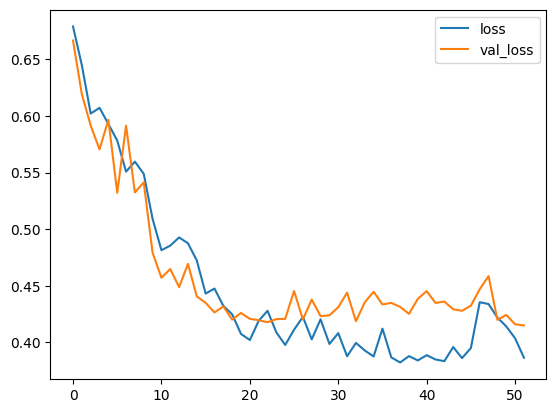

In [16]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')

plt.legend()

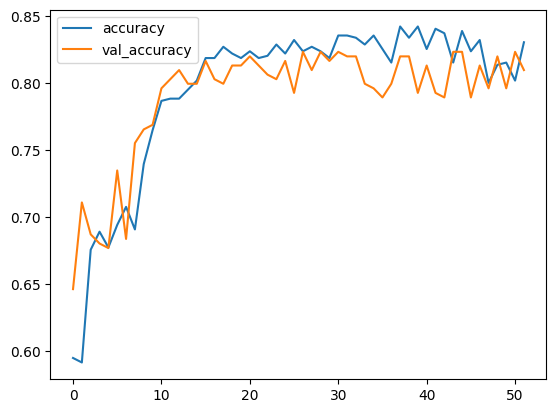

In [17]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')

plt.legend()

In [18]:
#Evaluate Split Train Data
split_evals = model.evaluate(
    x_test,
    y_test
)

10/10 [==============================] - 0s 5ms/step - loss: 0.4149 - accuracy: 0.8095


In [19]:
#Evaluate with merged submission sample
(x_valid, y_valid) = label_data_split(df_valid)

x_valid = dataScaler.transform(x_valid)

merged_evals = model.evaluate(
    x_valid,
    y_valid
)

14/14 [==============================] - 0s 6ms/step - loss: 0.3189 - accuracy: 0.9233


<BarContainer object of 4 artists>

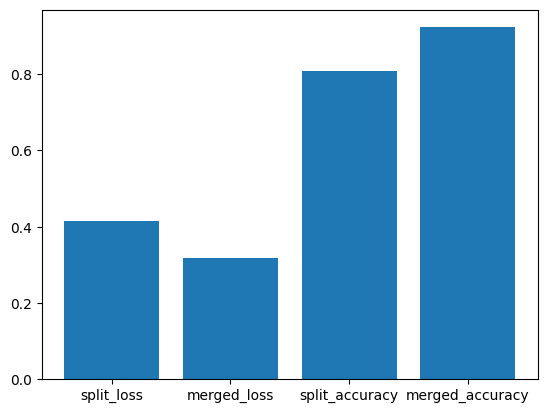

In [20]:
labels = ["split_loss", "merged_loss", "split_accuracy", "merged_accuracy"]
values = [split_evals[0], merged_evals[0], split_evals[1], merged_evals[1]]

plt.bar(labels, values)

## Create Submission

In [21]:
prediction_df = pd.read_csv('/content/test.csv')

prediction_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
prediction_df_processed = manual_preprocess_df(prediction_df)

prediction_df_processed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,2
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,2
4,3,1,22.0,1,1,12.2875,2


In [23]:
prediction_df_processed['Fare'] = prediction_df_processed['Fare'].fillna(prediction_df_processed['Fare'].mean())

In [24]:
x_prediction = dataScaler.transform(prediction_df_processed)

In [25]:
predictions = model.predict(
    x_prediction
)

14/14 [==============================] - 0s 5ms/step


In [26]:
result_df = pd.DataFrame(prediction_df)
result_df['Survived'] = predictions
result_df['Survived'] = result_df['Survived'].apply(lambda x: 1 if x > 0.5 else 0)


result_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [27]:
result_df.drop(columns=[col for col in result_df.columns if col not in ['PassengerId', 'Survived']], inplace=True)

10/10 [==============================] - 0s 5ms/step
Accuracy: 0.8095238095238095
F1 Score: 0.7199999999999999
Confusion Matrix:
 [[166  24]
 [ 32  72]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       190
           1       0.75      0.69      0.72       104

    accuracy                           0.81       294
   macro avg       0.79      0.78      0.79       294
weighted avg       0.81      0.81      0.81       294



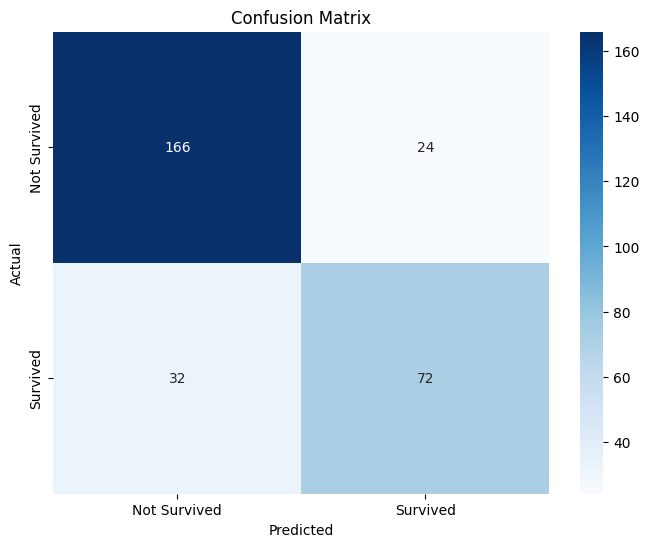

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Calculate predicted probabilities
y_pred_probs = model.predict(x_test)

# Convert probabilities to binary predictions (0 or 1) based on a threshold, e.g., 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Detailed classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Plotting using seaborn for a nicer look
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



ROC-AUC Score: 0.8645242914979757
Precision-Recall AUC: 0.8306720091148082


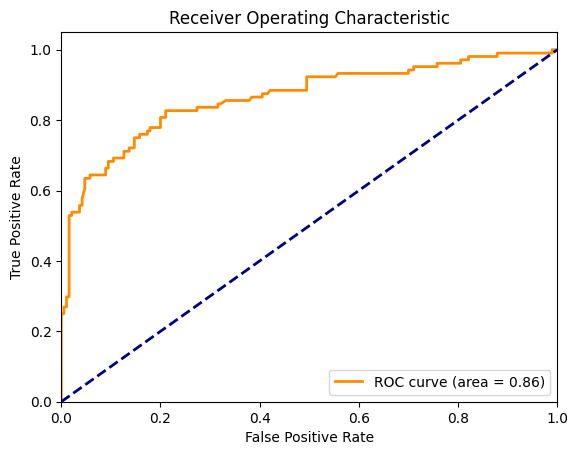

In [29]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print("ROC-AUC Score:", roc_auc)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)



# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [30]:
result_df.to_csv('/content/submission.csv')

In [31]:
model.save('/content/mymodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 54.4 MB/s eta 0:00:00


In [33]:
!tensorflowjs_converter --input_format keras mymodel.h5 /content/tfjs_model


2024-01-20 17:15:24.375988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 17:15:24.376029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 17:15:24.377227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 17:15:25.450223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from google.colab import files
!zip -r /content/tfjs_model.zip /content/tfjs_model
files.download('/content/tfjs_model.zip')

updating: content/tfjs_model/ (stored 0%)
updating: content/tfjs_model/model.json (deflated 83%)
updating: content/tfjs_model/group1-shard1of1.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>